# YOLOv3 - opencv


## Load pretrained model (weights)

In [1]:
# Get weights & config
#!mkdir yolo_files

#!wget -O ./yolo_files/yolov3.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
#!wget -O ./yolo_files/coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
#!wget -O ./yolo_files/yolov3.weights https://pjreddie.com/media/files/yolov3.weights

## Load libraries

In [2]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Let us load COCO dataset classes and the model with it's pre-trained weights on the same dataset.

In [3]:
# Load names of classes
classesFile = "./yolo_files/coco.names";
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
model_configuration = "./yolo_files/yolov3.cfg";
model_weights = "./yolo_files/yolov3.weights";

# Load pretrained weights 
net = cv2.dnn.readNetFromDarknet(model_configuration, model_weights)

# set opencv backend and CPU inference
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [4]:
print("Number of classes:", len(classes), "\n", classes)

Number of classes: 80 
 ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


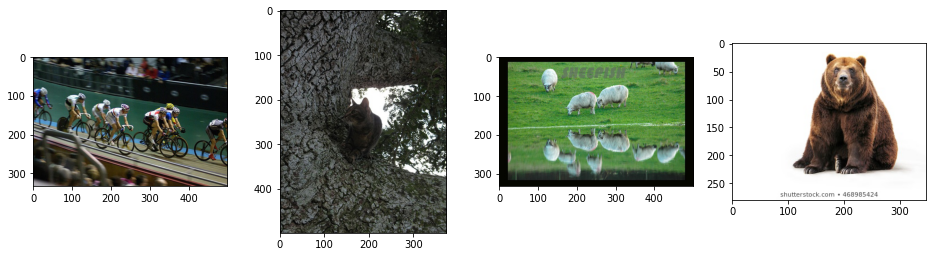

In [5]:
# show images
IMG_PATHS = [
    './images/img1.jpg',
    './images/img2.jpg',
    './images/img3.jpg',
    './images/img4.jpg',
]

plt.figure(figsize=(16, 9))

for img in IMG_PATHS:
    image = mpimg.imread(img)
    plt.subplot(2, 4, IMG_PATHS.index(img)+1)
    plt.imshow(image)

## Inference 

In [6]:
# Initialize global parameters for yolo
conf_threshold = 0.5  # Confidence threshold
nms_threshold = 0.4   #Non-maximum suppression threshold
input_width = 416       #Width of network's input image
input_height = 416      #Height of network's input image

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

def yolo_inference(img, model):
    """
    A function that takes an image and a yolo model and return outputs of the model 
    img: str to the path
    model: loaded model
    """
    # Define the input
    input_img = cv2.imread(img)
    #input_img = cv2.resize(input_img,None,fx=0.5,fy=0.5)

    blob = cv2.dnn.blobFromImage(input_img,1/255,(input_width,input_height),(0,0,0),True,crop=False)
    model.setInput(blob)

    # Get the output layer in the architecture
    layer_names = model.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in model.getUnconnectedOutLayers()]

    # Forward pass
    outs = model.forward(output_layers)

    return outs, input_img


In [7]:
# Run inference on all images 
import time 

outs = []
input_imgs = [] 

start_time = time.time()
for img_path in IMG_PATHS:
    out, input_img = yolo_inference(img_path, net)
    outs.append(out)
    input_imgs.append(input_img)

print('inference time (on 4 images) in seconds: ', time.time() - start_time)

inference time (on 4 images) in seconds:  3.7323977947235107


## Post-processing of bbox

In [12]:
# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    conf = '%.2f' % confidence
    # Get the label for the class name and its confidence
    text = '%s:%s' % (label, conf)

    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    
    labelSize, baseLine = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, 0.5, 1)
    top = max(y, labelSize[1])
    cv2.putText(img, text, (x, top), cv2.FONT_HERSHEY_PLAIN, 0.4, (255,255,255))


def post_process(input_img, outs):
    """
    Select boxes to show on an image and remove useless ones.
    return the imqge with boxes.
    """
    Width = input_img.shape[1]
    Height = input_img.shape[0]
    index = 0

    class_ids = []
    confidences = []
    boxes = []
    # for each detetion from each output layer 
    # get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
            
    # apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # go through the detections remaining
    # after nms and draw bounding box
    output_boxes = []
    output_confidences = []
    output_classes = []
    
    for i in indices:
        i = i[0]
        x, y, w, h = boxes[i]
        output_boxes.append(boxes[i])
        output_classes.append(class_ids[i])
        output_confidences.append(confidences[i])
        
        draw_bounding_box(input_img, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

    return input_img, output_boxes, output_confidences, output_classes


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


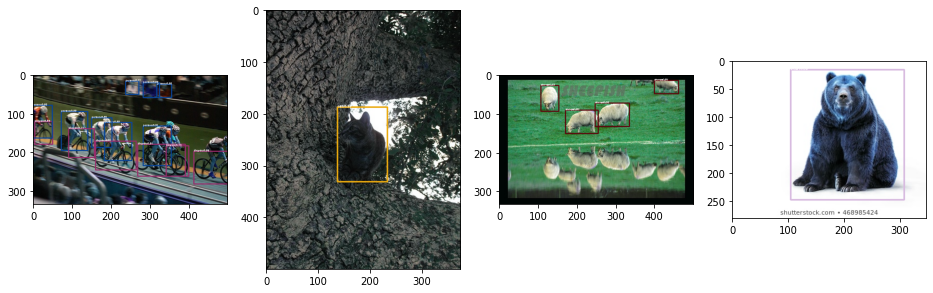

In [13]:
plt.figure(figsize=(16, 12))
confidences = []
output_classes = []

for (img, out) in zip(input_imgs, outs):
    img_with_bbox, c, cfd, classe = post_process(img, out)
    confidences.append(cfd)
    output_classes.append(classe)
    plt.subplot(2, 4, input_imgs.index(img)+1)
    plt.imshow(img_with_bbox)

In [14]:
for (img, classe, confidence)  in zip(IMG_PATHS, output_classes, confidences):
    print('#'*30)
    print('predictions on', img)
    for c_id, cfd in zip(classe, confidence):
        label = str(classes[c_id])
        conf = '%.2f' % cfd
        # Get the label for the class name and its confidence
        text = '%s:%s' % (label, conf)
        print(text)

##############################
predictions on ./images/img1.jpg
person:0.99
person:0.99
bicycle:0.98
person:0.96
person:0.95
bicycle:0.94
person:0.91
bicycle:0.91
person:0.88
person:0.85
person:0.77
bicycle:0.77
bicycle:0.74
bicycle:0.66
##############################
predictions on ./images/img2.jpg
cat:0.98
##############################
predictions on ./images/img3.jpg
sheep:0.95
sheep:0.93
sheep:0.81
sheep:0.80
##############################
predictions on ./images/img4.jpg
bear:0.93


In [11]:
#Imad El Hanafi